In [0]:
import pandas as pd
import numpy
from keras.datasets import imdb
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
import numpy as np
numpy.random.seed(10)
import spacy
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, f1_score
from keras.preprocessing.text import Tokenizer, text_to_word_sequence, one_hot
from keras.callbacks import Callback, ModelCheckpoint
import pickle
from keras.models import model_from_json
import itertools

Using TensorFlow backend.


In [0]:
class F1_Score(Callback):
    def __init__(self, training_data):
        self.training_data = training_data
        super().__init__() 

    def on_train_begin(self, logs={}):
        self.train_f1s = []
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs={}):
        train_predict = np.rint(self.model.predict(self.training_data[0]))
        train_targ = self.training_data[1]
        _train_f1 = f1_score(train_targ, train_predict, average='weighted')
        self.train_f1s.append(_train_f1)
        print(" — train_f1: %.4f" % _train_f1)
        
        val_predict = np.rint(self.model.predict(self.validation_data[0]))
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict, average='weighted')
        print(classification_report(val_targ, val_predict))
        self.val_f1s.append(_val_f1)
        print(" — val_f1: %.4f" % _val_f1)
        return

In [0]:

def train_test(df, proportion=[.7,.9]):
    train_df = pd.DataFrame() 
    dev_df = pd.DataFrame() 
    test_df = pd.DataFrame() 
    exercises_names = df['exercise.name'].unique()
    for exercise in exercises_names:
        df_exer = df[df['exercise.name'] == exercise]
        train, dev  = np.split(df_exer.sample(frac=1), [int(.7*len(df_exer))])
        print(train.shape, dev.shape, exercise)
        train_df = train_df.append(train, ignore_index=True)
        dev_df = dev_df.append(dev, ignore_index=True)
    return train_df, dev_df

In [0]:
import os
os.listdir('.')

['.config', 'sample_data']

In [0]:
from google.colab import files
uploaded = files.upload()

Saving IO_final_df.pkl to IO_final_df.pkl
Saving tokenizer-io.pkl to tokenizer-io.pkl
Saving IO.10-0.81.h5 to IO.10-0.81.h5


In [0]:
#submissions = pd.read_pickle('mumuki_io_FINAL_anotado.pkl')
submissions = pd.read_pickle('test-df-IO-256-predicted2.pkl')

In [0]:
#print(submissions_intro[(submissions_intro['student.email'] == 'pl.roldan1@gmail.com') & (submissions_intro['exercise.name'] == 'esBisiesto')].loc[9115])
#switchea exercise
#submissions_intro[(submissions_intro['student.email'] == 'pl.roldan1@gmail.com') & (submissions_intro['exercise.name'] == 'esBisiesto')].loc[8736]['content']

In [0]:
submissions['target'] = submissions.apply(lambda x: 1 if x['dropout_tray'] else 0, axis=1)

In [0]:
train_df = pd.read_pickle('IntroAlgo_final.pkl')
#test_df = pd.read_pickle('test_df_two_less_students_by_ratio.pkl')

In [0]:
train_df, test_df = train_test(submissions)

In [0]:
test_df = train_df[train_df['student.email'] == 'joaquinprotti@hotmail.com']
train_df = train_df.drop(train_df[(train_df['student.email'] == 'joaquinprotti@hotmail.com')].index)

In [0]:
X_train = train_df['content'].values
Y_train = train_df['target'].values
X_test = test_df['content'].values
Y_test = test_df['target'].values

In [0]:
#tokenizer = Tokenizer()
#tokenizer = Tokenizer(filters='', lower=False)
tokenizer = Tokenizer(num_words=35000, oov_token="<UNK>", lower=False, filters='')
tokenizer.fit_on_texts(X_train)

In [0]:
#Save tokenizer
with open('tokenizer-intro.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#load tokenizer
#with open('tokenizerIntro.pickle', 'rb') as handle:
#    tokenizer = pickle.load(handle)

In [0]:
files.download('test_df_intro_30.pkl')

In [0]:
max_length = 100
top_words = 5000
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [0]:
sorted(tokenizer.word_counts.items(), key=lambda kv: -kv[1])


### Amount of tokens

In [0]:
print(len(list(itertools.chain.from_iterable(np.array(X_train)))))
print(len(tokenizer.index_word.values()))

2164276
64551


In [0]:
X_train = sequence.pad_sequences(X_train, maxlen=max_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_length)

In [0]:
!pip install tensorboardcolab

In [0]:
from tensorboardcolab import *
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://96557fbb.ngrok.io


In [0]:
import tensorflow as tf
from keras import backend as K


config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
sess = tf.Session(config=config)
K.set_session(sess)

callbacks = [F1_Score((X_train, Y_train)), ModelCheckpoint("introAlgo.{epoch:02d}-{val_loss:.2f}.h5", monitor="val_loss", save_best_only=False, period=1)]

# create the model
embedding_vecor_length = 256
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_length))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
res = model.fit(np.array(X_train), Y_train, validation_data=(np.array(X_test), Y_test), epochs=20, batch_size=32, callbacks=callbacks)

W0723 02:04:38.095117 139639751010176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 02:04:38.097790 139639751010176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 02:04:38.106700 139639751010176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 02:04:38.509608 139639751010176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0723 02:04:38.519555 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 256)          1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               142800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,422,901
Trainable params: 1,422,901
Non-trainable params: 0
_________________________________________________________________
None
Train on 18841 samples, validate on 336 samples
Epoch 1/20
18841/18841 [==============================] - 86s 5ms/step - loss: 0.5147 - acc: 0.7411 - val_loss: 0.6776 - val_acc: 0.6190
 — train_f1: 0.8480
              precision    recall  f1-score   support


In [0]:
import os
os.listdir('.')
files.download('introAlgo.10-0.44.h5')

In [0]:
model = load_model('introAlgo.29-0.76.h5')

In [0]:
#compile loaded model
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model = loaded_model

In [0]:
test_df['predicted_classes'] = model.predict_classes(sequence.pad_sequences(tokenizer.texts_to_sequences(test_df['content']),maxlen=max_length))
test_df['predicted'] = model.predict(sequence.pad_sequences(tokenizer.texts_to_sequences(test_df['content']),maxlen=max_length))

In [0]:
files.download('introAlgo.06-0.46.h5')

In [0]:
test_df.to_pickle('test-df-IO-256-predicted2.pkl')

In [0]:
files.download('test-df-IO-256-predicted2.pkl')

In [0]:
submissions = pd.read_pickle('test-df-intro-256-predicted2.pkl')

In [0]:
def get_prediction(model, sub_content):
    max_length = 100
    return model.predict_proba(sequence.pad_sequences(sub_content,maxlen=max_length))

In [0]:
for exercise in test_df['exercise.name'].unique():
    print(exercise, test_df[test_df['exercise.name']==exercise].shape[0])

Los operadores son funciones 697
Más composición 1023
esBisiesto 5903
Composición 1516
Combinando funciones 900
Triángulos 692
Múltiples parámetros 707
esNumeroPositivo 466
Los booleanos 556
Más funciones 729
Las Funciones 637
Más valores 904
Valores y variables 878
Los números 768
El caso base 265
¡Terminala! Parte 2 269
esMultiploDe 3460
mitad 625
esMultiploDeTres 3049
siguiente 436
Dispersión 960
Pinos 1091
aplanar 86
Orden de las Condiciones 824
promediosSinAplazos 1150
promedios 606
pertenece 457
fibonacci 258
interseccion 478
No todo lo que brilla es Oro 528
Pattern Matching con Tuplas 398
Tipando tuplas 725
Otherwise 525
Puntos Para Setenta! 1993
Guardas: Básico 520
Pausa: Volvieron los tipos 375
Variable Anónima 583
Cuando los patrones no encajan 359
La historia sin fin 563
diferencias 299
zipWith 131
transformadaLoca 293
intercalar 165
filtrar 115
sinRepetidos 186
menoresA 241
maximo 225
productoria 200
alVesre 141
maximoSegun 262
Iterar 821
Área 202
fahrToCelsius 672
celsiusT

In [0]:
df = test_df[test_df['exercise.name'] == 'esBisiesto']
df[df['target'] == df['predicted_classes']].shape[0]/df.shape[0]

0.8402948402948403

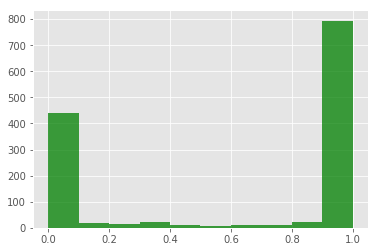

In [0]:
import numpy as np
import matplotlib.pyplot as plt


n, bins, patches = plt.hist(df['predicted'], facecolor='g', alpha=0.75)


plt.grid(True)
plt.show()

In [0]:
submissions[(submissions['target'] == 1) & (submissions['predicted'] >= 0.8)][['content', 'exercise.name','target','predicted_classes', 'predicted']]
# print(submissions[(submissions['predicted'] > 0.3) & (submissions['predicted'] < 0.5)][['content', 'submissions_status','target', 'predicted']].iloc[10,:]['content'])
# print(submissions[(submissions['predicted'] > 0.3) & (submissions['predicted'] < 0.5)][['content', 'submissions_status','target', 'predicted']].iloc[10,:]['target'])
# print(submissions[(submissions['predicted'] > 0.3) & (submissions['predicted'] < 0.5)][['content', 'submissions_status','target', 'predicted']].iloc[10,:]['predicted'])
# submissions.sort_values('predicted', ascending=True)

,content,exercise.name,target,predicted_classes,predicted
20843,Másdos==siguiente numero = 2 + numero,Más composición,1,1,0.999967
20842,Másdos= 2 + (siguiente numero),Más composición,1,1,0.999967
20841,Másdos=2 + (siguiente numero),Más composición,1,1,0.999992
20840,Másdos=2 + numero,Más composición,1,1,0.999992
20839,siguiente=num a => a -> a -> a,Más composición,1,1,0.999608
20838,siguiente=(Número) +2,Más composición,1,1,0.999999
20837,siguiente=(Número +2),Más composición,1,1,1.000000
20836,Masdos.siguiente=(Número +2),Más composición,1,1,0.997449
20835,Masdos= (Número +2),Más composición,1,1,1.000000
20834,Masdos= Siguientenúmero. (Número +2),Más composición,1,1,1.000000


In [0]:
print(submissions.loc[8725]['predicted_classes'])
print(submissions.loc[8725]['predicted'])
print(submissions.loc[8725]['content'])

for i in tokenizer.texts_to_sequences([submissions.loc[8725]['content']]):
    print(i)

1
0.5899417
esBisiesto numero = (esMultiploDe numero 400 && esMultiploDe numero 4 && not(esMultiploDe numero 100))
[32, 11, 1, 68, 11, 47, 13, 30, 11, 31, 13, 315, 11, 365]


In [0]:
#get_prediction(model, [submissions.loc[8725]['content']])
#sequence.pad_sequences(tokenizer.texts_to_sequences(submissions['content']),maxlen=max_length)

#Tokenizo la solucion
tokenized = tokenizer.texts_to_sequences([submissions.loc[8725]['content']])[0]

#ventada de 1, voy sacando de a un token y padeo 
to_train = [(tokenized[i], tokenized[:i]+tokenized[i+1:]) for i in range(len(tokenized))]

In [0]:
to_train

[(32, [11, 1, 68, 11, 47, 13, 30, 11, 31, 13, 315, 11, 365]),
 (11, [32, 1, 68, 11, 47, 13, 30, 11, 31, 13, 315, 11, 365]),
 (1, [32, 11, 68, 11, 47, 13, 30, 11, 31, 13, 315, 11, 365]),
 (68, [32, 11, 1, 11, 47, 13, 30, 11, 31, 13, 315, 11, 365]),
 (11, [32, 11, 1, 68, 47, 13, 30, 11, 31, 13, 315, 11, 365]),
 (47, [32, 11, 1, 68, 11, 13, 30, 11, 31, 13, 315, 11, 365]),
 (13, [32, 11, 1, 68, 11, 47, 30, 11, 31, 13, 315, 11, 365]),
 (30, [32, 11, 1, 68, 11, 47, 13, 11, 31, 13, 315, 11, 365]),
 (11, [32, 11, 1, 68, 11, 47, 13, 30, 31, 13, 315, 11, 365]),
 (31, [32, 11, 1, 68, 11, 47, 13, 30, 11, 13, 315, 11, 365]),
 (13, [32, 11, 1, 68, 11, 47, 13, 30, 11, 31, 315, 11, 365]),
 (315, [32, 11, 1, 68, 11, 47, 13, 30, 11, 31, 13, 11, 365]),
 (11, [32, 11, 1, 68, 11, 47, 13, 30, 11, 31, 13, 315, 365]),
 (365, [32, 11, 1, 68, 11, 47, 13, 30, 11, 31, 13, 315, 11])]

In [0]:
def print_tokenized(tokenizer, tokens):
    string = ''
    for token in tokens:
        string += tokenizer.index_word[token]+' '
    print(string)

print_tokenized(tokenizer,tokenized)
print(get_prediction(model, [tokenized])[0][0])
print('\n')


for elem in to_train:
    print("Remove token {}".format(tokenizer.index_word[elem[0]]))
    print_tokenized(tokenizer, elem[1])
    print(get_prediction(model, [elem[1]])[0][0])
    print('\n')

esbisiesto numero = (esmultiplode numero 400 && esmultiplode numero 4 && not(esmultiplode numero 100)) 
0.58994174


Remove token esbisiesto
numero = (esmultiplode numero 400 && esmultiplode numero 4 && not(esmultiplode numero 100)) 
0.48377174


Remove token numero
esbisiesto = (esmultiplode numero 400 && esmultiplode numero 4 && not(esmultiplode numero 100)) 
0.3486017


Remove token =
esbisiesto numero (esmultiplode numero 400 && esmultiplode numero 4 && not(esmultiplode numero 100)) 
0.5826088


Remove token (esmultiplode
esbisiesto numero = numero 400 && esmultiplode numero 4 && not(esmultiplode numero 100)) 
0.5327633


Remove token numero
esbisiesto numero = (esmultiplode 400 && esmultiplode numero 4 && not(esmultiplode numero 100)) 
0.31585565


Remove token 400
esbisiesto numero = (esmultiplode numero && esmultiplode numero 4 && not(esmultiplode numero 100)) 
0.8387301


Remove token &&
esbisiesto numero = (esmultiplode numero 400 esmultiplode numero 4 && not(esmultiplode nume

Index(['content', 'guide.name', 'datetime', 'student.email', 'distance',
       'time_dist', 'exercise.eid', 'exercise.name', 'submissions_status',
       'submissions_count', 'switch_exercise', 'dropout_switch',
       'dropout_session', 'dropout_session_tray', 'dropout_switch_tray',
       'dropout', 'dropout_tray', 'PSA', 'PCA', 'PCAM', 'PA', 'EA', 'PPA',
       'PTT', 'PDL', 'IPA', 'PCSA', 'APE', 'CAPE', 'COMP', 'target'],
      dtype='object')

# Character Level LSTM

In [0]:

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, BatchNormalization, Dropout
from keras import optimizers
from keras.utils import to_categorical

In [0]:
# some parameters
BATCH_SIZE = 1024  # batch size for the network
EPOCH_NUMBER = 10  # number of epochs to train
THRESHOLD = 5  # symbols appearing fewer times will be replaced by a placeholder

In [0]:
x_train = train_df['content']
y_train = train_df['target']
# An important statistic is the average length of the comment:

x_train.apply(lambda x: len(x)).describe()

count    15468.000000
mean        90.567430
std         73.809111
min          1.000000
25%         37.000000
50%         66.000000
75%        120.000000
max        586.000000
Name: content, dtype: float64

In [0]:
# Get counts of unique symbols in the training set:

unique_symbols = Counter()

for _, program in x_train.iteritems():
    unique_symbols.update(program)
    
print("Unique symbols:", len(unique_symbols))
print(unique_symbols)

Unique symbols: 132
Counter({' ': 345450, 'e': 77157, 'o': 73863, 'a': 71085, 's': 59288, 'n': 52387, 'i': 51497, 'r': 48796, 't': 46265, '=': 40531, 'l': 28098, 'd': 27832, '\n': 26985, '\r': 26983, 'x': 25354, '(': 23619, ')': 23559, 'c': 23053, 'u': 23003, 'm': 22379, 'p': 18525, ':': 16278, '0': 15178, '>': 13644, '-': 11493, '|': 10980, 'b': 9918, '1': 9903, 'I': 8922, 'h': 8178, '2': 8031, 'P': 8018, 'y': 7732, ',': 7587, 'D': 7392, 'f': 6460, '[': 6390, ']': 6373, 'F': 6126, 'B': 5960, '&': 5529, '3': 5389, 'g': 4889, '4': 4373, 'M': 4362, '*': 4340, '+': 4209, '<': 4079, 'C': 3963, 'T': 3825, '"': 3817, 'z': 3610, 'S': 3251, 'A': 2895, 'N': 2633, 'L': 2387, '.': 2293, 'v': 2156, "'": 1867, '/': 1854, 'U': 1723, '5': 1703, 'w': 1538, '6': 1533, 'V': 1505, 'E': 1163, 'R': 1163, 'j': 1138, '8': 862, '_': 835, '9': 798, 'O': 777, 'q': 765, '^': 590, 'G': 557, '!': 336, '`': 257, '¡': 254, '7': 221, 'ñ': 204, '│': 182, 'ó': 174, 'á': 92, 'k': 63, '´': 51, '\\': 41, 'J': 36, 'ú': 29,

In [0]:
# Find symbols that appear fewer times than the threshold:
uncommon_symbols = list()

for symbol, count in unique_symbols.items():
    if count < THRESHOLD:
        uncommon_symbols.append(symbol)

print("Uncommon symbols:", len(uncommon_symbols))
print(uncommon_symbols)

Uncommon symbols: 25
['$', '@', '○', '☺', '♣', '◘', '♠', '♥', '☻', '•', '■', '¹', '¸', '↑', '?', '¿', '÷', '±', 'χ', 'ª', '’', '–', '‘', 'W', 'ì']


In [0]:
# Replace them with a placeholder:

DUMMY = uncommon_symbols[0]
tr_table = str.maketrans("".join(uncommon_symbols), DUMMY * len(uncommon_symbols))

x_train = x_train.apply(lambda x: x.translate(tr_table))

In [0]:
# We will need the number of unique symbols further down when we will decide on the dimensionality of inputs.

num_unique_symbols = len(unique_symbols) - len(uncommon_symbols) + 1 

tokenizer = Tokenizer(
    char_level=True,
    filters=None,
    lower=False,
    num_words=num_unique_symbols
)

tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [0]:
# Pad the input: I use the 100 lenght, just a bit over the median length.

padded_sequences = pad_sequences(sequences, maxlen=100)

# I will take just a bit of the data as the validation set to see that the network converges:

x_train, x_val, y_train, y_val = train_test_split(padded_sequences, y_train, test_size=0.05)

# So, let's define the model!
model = Sequential()
model.add(LSTM(150, input_shape=(100, num_unique_symbols), activation="tanh", return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(LSTM(100, input_shape=(100, num_unique_symbols), activation="tanh"))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(100, activation="tanh"))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(50, activation="tanh"))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))

x_val = to_categorical(np.array(x_val), num_classes=num_unique_symbols)

# Let's track the performance using the custom function that will be used for the leaderboard:

sgd = optimizers.SGD(lr=0.01, momentum=0.9)
#model.compile(optimizer=sgd, loss="binary_crossentropy")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
def kaggle_loss(y_true, y_pred):
    total_loss = 0
    for i in range(y_true.shape[1]):
        total_loss += log_loss(y_true.iloc[:, i], y_pred[:, i])
    return total_loss / y_true.shape[1]


with open("res_2.txt", "w") as f:
    print(model.summary())
    for epoch in range(EPOCH_NUMBER):
        print("Epoch", epoch)
        for i in range(0, len(x_train), BATCH_SIZE):
            batch = x_train[i:i+BATCH_SIZE]
            batch = to_categorical(batch, num_classes=num_unique_symbols)
            y_batch = y_train.iloc[i:i+BATCH_SIZE]
            model.fit(batch, y_batch, batch_size=256)
        #res = kaggle_loss(y_val, model.predict_proba(x_val))
        print("Loss:", res)
        f.write("{}: {}\n".format(epoch, res))
        model.save("lstm_2_50_ep{}.h5".format(epoch + 1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 100, 150)          155400    
_________________________________________________________________
batch_normalization_45 (Batc (None, 100, 150)          600       
_________________________________________________________________
dropout_45 (Dropout)         (None, 100, 150)          0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 100)               100400    
_________________________________________________________________
batch_normalization_46 (Batc (None, 100)               400       
_________________________________________________________________
dropout_46 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 100)               10100     
__________

# Language Models
Build and train two differents language model one for non dropout sumbissions and another for dropout submissions.

In [0]:
import os
os.listdir('.')

['.config',
 'IntroAlgo128-predicted.pkl',
 'language-model-intro-128.h5',
 'language-model-intro-128.json',
 'sample_data']

In [0]:
from google.colab import files
uploaded = files.upload()

Saving IntroAlgo128-predicted.pkl to IntroAlgo128-predicted.pkl


In [0]:
submissions = pd.read_pickle('IntroAlgo128-predicted.pkl')

In [0]:
dropout_submissions = submissions[submissions['predicted'] == 1]
dropout_submissions.shape

(10796, 32)

In [0]:
train_dropout_df, test_dropout_df = train_test(dropout_submissions)

(116, 32) (30, 32) calcular
(164, 32) (42, 32) Más composición
(65, 32) (17, 32) maximo
(108, 32) (27, 32) diferencias
(110, 32) (28, 32) menoresA
(51, 32) (13, 32) productoria
(64, 32) (16, 32) transformadaLoca
(77, 32) (20, 32) fibonacci
(136, 32) (35, 32) La historia sin fin
(35, 32) (9, 32) ¡Terminala! Parte 2
(62, 32) (16, 32) esMayorDeEdad
(88, 32) (22, 32) cuentaBizarra
(176, 32) (44, 32) Pattern Matching con Tuplas
(178, 32) (45, 32) aplicar2-upla
(172, 32) (44, 32) Tipando tuplas
(103, 32) (26, 32) Puntos Para Setenta!
(112, 32) (28, 32) Variable Anónima
(105, 32) (27, 32) Cuando los patrones no encajan
(317, 32) (80, 32) No todo lo que brilla es Oro
(323, 32) (81, 32) Orden de las Condiciones
(124, 32) (31, 32) Guardas: Básico
(37, 32) (10, 32) intercalar
(33, 32) (9, 32) maximoSegun
(47, 32) (12, 32) filtrar
(17, 32) (5, 32) zipWith
(35, 32) (9, 32) alVesre
(132, 32) (34, 32) promedios
(53, 32) (14, 32) sinRepetidos
(119, 32) (30, 32) pertenece
(260, 32) (65, 32) notas
(43, 

In [0]:
X_train_dropout = train_dropout_df['content'].values
Y_train_dropout = train_dropout_df['target'].values
X_test_dropout = test_dropout_df['content'].values
Y_test_dropout = test_dropout_df['target'].values

In [0]:
data = ''
for elem in X_train_dropout:
    data += elem.strip()+' </s></s> '

In [0]:
print(data)

calcular (a, b) | fst(a,b)==2* fst(a, b)= 2*fst(a,b)
            |snd(a,b)==2*snd(a,b) +1 = snd (a,b) +1  </s></s> par n = mod n 2 == 0
impar n = not par n
calcular (a,b) | par a = ((2*a),b) || impar b = (a, (b + 1))
               | otherwise = (a,b)
                </s></s> calcular (x,y) | mod x 2 == 0 = (x * 2,)
               | mod x 2 /= 0 = (x,y)

calcular (x,y) | mod y 2 /= 0 = (x,y + 1)
               | mod y 2 == 0 = (x,y)  </s></s> calcular :: (Int , Int) -> (Int , Int)

calcular (x , y) | mod x 2 == 0 = x * 2
                 | mod x 2 /= 0 = x
                 | mod y 2 == 0 = y
                 | mod y 2 /= 0 = y+1
                  </s></s> calcular :: (Int,Int) -> (Int,Int)
calcular (a,b) | mod b 2 == 1 = (a,b+1)
               | mod a 2 == 0 = (a*2,b)
               | mod a 2 /= 0 = (a,b)
               | mod b 2 /= 1 = (a,b) </s></s> calcular (a, b) | mod a 2 == 0 = a * 2
                | mod a 2 == 1 = a
                | mod b 2 == 0 = b
                | mod b 2 =

In [0]:
# integer encode text
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(X_train_dropout)
encoded = tokenizer.texts_to_sequences(X_train_dropout)[0]

In [0]:
tokenizer.word_counts

OrderedDict([('calcular', 102),
             ('(a,', 289),
             ('b)', 342),
             ('|', 4738),
             ('fst(a,b)==2*', 1),
             ('fst(a,', 4),
             ('b)=', 1),
             ('2*fst(a,b)\r\n', 3),
             ('|snd(a,b)==2*snd(a,b)', 1),
             ('+1', 14),
             ('=', 15371),
             ('snd', 197),
             ('(a,b)', 402),
             ('par', 31),
             ('n', 2348),
             ('mod', 599),
             ('2', 595),
             ('==', 1606),
             ('0\r\nimpar', 6),
             ('not', 561),
             ('n\r\ncalcular', 6),
             ('a', 3255),
             ('((2*a),b)', 4),
             ('||', 495),
             ('impar', 12),
             ('b', 1783),
             ('(b', 91),
             ('+', 1280),
             ('1))\r\n', 13),
             ('otherwise', 706),
             ('(a,b)\r\n', 30),
             ('(x,y)', 211),
             ('x', 5677),
             ('0', 743),
             ('(x', 395),
 

In [0]:
sorted(tokenizer.word_counts.items(), key=lambda kv: -kv[1])

[('=', 15371),
 ('x', 5677),
 ('->', 4924),
 ('|', 4738),
 ('::', 3385),
 ('a', 3255),
 ('int', 2834),
 ('n', 2348),
 ('b', 1783),
 ('>', 1753),
 ('&&', 1736),
 ('==', 1606),
 ('<', 1543),
 ('+', 1280),
 ('y', 1276),
 ('numero', 1243),
 ('*', 1185),
 ('[]', 1037),
 ('c', 986),
 ('3', 847),
 ('\r\n', 775),
 ('(x:xs)', 754),
 ('float', 744),
 ('0', 743),
 ('otherwise', 706),
 ('xs', 641),
 (':', 608),
 ('mod', 599),
 ('2', 595),
 ('4', 584),
 ('not', 561),
 ('esmultiplode', 554),
 ('esbisiesto', 537),
 ('1', 524),
 ('||', 495),
 ('pesopino', 489),
 ('>=', 470),
 ('<=', 447),
 ('z', 441),
 ('esnotabochazo', 414),
 ('esmultiplodetres', 412),
 ('num', 403),
 ('(a,b)', 402),
 ('-', 396),
 ('(x', 395),
 ('200', 378),
 ('400', 371),
 ('persona', 367),
 ('(dispersion', 353),
 ('4\r\n', 343),
 ('b)', 342),
 ('2\r\n', 339),
 ('dispersion', 339),
 ('c)', 336),
 ('p', 335),
 ('true', 333),
 ('false', 331),
 ('true\r\n', 322),
 ('x)', 321),
 ('siempredicelaverdad', 316),
 ('horasduerme', 307),
 ('6'

In [0]:
# determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 5815


In [0]:
#tokenizer.texts_to_sequences([data.split('</s></s>')[0]])[0]

In [0]:
# create line-based sequences
sequences = list()
for line in data.split('</s></s>'):
    encoded = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

print('Total Sequences: %d' % len(sequences))

Total Sequences: 119868


In [0]:
# pad input sequences
max_length = max([len(seq) for seq in sequences])
max_length = 20
sequences = seq.pad_sequences(sequences, maxlen=max_length, padding='pre')
print('Max Sequence Length: %d' % max_length)

Max Sequence Length: 20


In [0]:
from keras.utils import to_categorical
# split into input and output elements
sequences = np.array(sequences)
X, y = sequences[:,:-1],sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)

In [0]:
sequences

array([[   0,    0,    0, ...,    0, 2526,   51],
       [   0,    0,    0, ..., 2526,   51,   46],
       [   0,    0,    0, ...,   51,   46,    4],
       ...,
       [   0,    0,    0, ...,    6,   24,  610],
       [   0,    0,    0, ...,   24,  610,    6],
       [   0,    0,    0, ...,  610,    6,   10]], dtype=int32)

In [0]:
X

array([[   0,    0,    0, ...,    0,    0, 2845],
       [   0,    0,    0, ...,    0, 2845,  106],
       [   0,    0,    0, ..., 2845,  106,   66],
       ...,
       [   0,    0,    0, ..., 1110, 5836,    1],
       [   0,    0,    0, ...,    0,    0,    9],
       [   0,    0,    0, ...,    0,    9,    1]], dtype=int32)

In [0]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
y.shape

(87160, 5841)

In [0]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=max_length-1))
model.add(LSTM(50))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())
# compile network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(X, y, epochs=50, verbose=2, batch_size=256)
#model.fit(X[:10000,:], y[:10000,:], epochs=500, verbose=2, batch_size=256)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 19, 10)            58150     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dense_4 (Dense)              (None, 5815)              296565    
Total params: 366,915
Trainable params: 366,915
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
 - 17s - loss: 5.7933 - acc: 0.1275
Epoch 2/50
 - 17s - loss: 5.4860 - acc: 0.1282
Epoch 3/50
 - 17s - loss: 5.4843 - acc: 0.1282
Epoch 4/50
 - 17s - loss: 5.4834 - acc: 0.1282
Epoch 5/50
 - 18s - loss: 5.4845 - acc: 0.1282
Epoch 6/50
 - 17s - loss: 5.4839 - acc: 0.1282
Epoch 7/50
 - 18s - loss: 5.4836 - acc: 0.1282
Epoch 8/50
 - 17s - loss: 5.4834 - acc: 0.1282
Epoch 9/50
 - 18s -

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("language-model-intro-nondropout-128.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("language-model-intro-nondropout-128.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
os.listdir('.')
files.download('language-model-intro-nondropout-128.h5')
files.download('language-model-intro-nondropout-128.json')

In [0]:
from google.colab import files
uploaded = files.upload()

Saving language-model-intro-nondropout-128.json to language-model-intro-nondropout-128.json
Saving language-model-intro-nondropout-128.h5 to language-model-intro-nondropout-128.h5


In [0]:
os.listdir('.')

['.config',
 'IntroAlgo128-predicted.pkl',
 'language-model-intro-nondropout-128.h5',
 'language-model-intro-nondropout-128.json',
 'language-model-intro-128.h5',
 'language-model-intro-128.json',
 'sample_data']

In [0]:
# load json and create model
json_file = open('language-model-intro-128.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
dropout_model = model_from_json(loaded_model_json)
# load weights into new model
dropout_model.load_weights("language-model-intro-128.h5")
print("Loaded model from disk")

Loaded model from disk


In [0]:
# load json and create model
json_file = open('language-model-intro-nondropout-128.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
no_dropout_model = model_from_json(loaded_model_json)
# load weights into new model
no_dropout_model.load_weights("language-model-intro-nondropout-128.h5")
print("Loaded model from disk")

Loaded model from disk


In [0]:
# generate a sequence from a language model
def generate_seq(model, tokenizer, max_length, seed_text, n_words):
	in_text = seed_text
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		# pre-pad sequences to a fixed length
		encoded = seq.pad_sequences([encoded], maxlen=max_length, padding='pre')
		# predict probabilities for each word
		yhat = model.predict_classes(encoded, verbose=0)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text += ' ' + out_word
	return in_text

In [0]:
print(generate_seq(dropout_model, tokenizer, max_length-1, 'calcular', 10))

calcular | c e c e 2
 1000
 otherwi = otherwi


In [0]:
print(generate_seq(no_dropout_model, tokenizer, max_length-1, 'calcular', 10))

calcular a int - int - int - (fun parejo 400
